# Notebook 2: Comprehensive EDA, Data Subsetting & Train/Val/Test Split

**Project:** DeepSpec-Tomato: A Dual-Stage CAE-CNN Diagnostic Framework  
**Author:** Muhammad Ali Tahir  
**Date:** 2025  

---

## 📋 Notebook Objectives

1. **Load configuration** from Notebook 1
2. **Subset Tomato data** — Copy only Tomato classes to project directory
3. **Exploratory Data Analysis** — Pixel distributions, RGB analysis, class comparisons
4. **Spectral signature analysis** — Biophysical pigment fingerprints per class
5. **Stratified data splitting** — 80% Train / 10% Val / 10% Test with no leakage
6. **Compute normalization statistics** — From training set ONLY
7. **Export split metadata** — For reproducibility in downstream notebooks

---

## ⚠️ Critical: Data Leakage Prevention

This notebook implements strict protocols to prevent data leakage:
- Normalization parameters (μ, σ) computed **only from training data**
- Stratified splitting maintains class proportions across all splits
- Random seed fixed for reproducibility

---

## 1. Environment Setup & Configuration Loading

In [2]:
# =============================================================================
# IMPORTS
# =============================================================================

import os
import sys
import json
import shutil
import warnings
from pathlib import Path
from datetime import datetime
from collections import defaultdict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import cv2

from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm

import torch
from torchvision import datasets, transforms

# Suppress warnings
warnings.filterwarnings('ignore')

# Display settings
pd.set_option('display.max_columns', None)
plt.style.use('seaborn-v0_8-whitegrid')
%matplotlib inline

# Set random seeds for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"Random seed: {RANDOM_SEED}")
print(f"Notebook executed at: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

PyTorch version: 2.7.0+cu128
CUDA available: True
Random seed: 42
Notebook executed at: 2026-01-27 18:13:23


In [3]:
# =============================================================================
# LOAD CONFIGURATION FROM NOTEBOOK 1
# =============================================================================

class ProjectPaths:
    """Centralized path management for the entire project."""
    
    ROOT = Path("/home/maliciit/ml-projects/python-projects/plant-village-cae")
    
    # Data paths
    DATA_RAW = ROOT / "data" / "raw"
    DATA_PROCESSED = ROOT / "data" / "processed"
    
    # Output paths
    NOTEBOOKS = ROOT / "notebooks"
    MODELS = ROOT / "models"
    OUTPUTS = ROOT / "outputs"
    CHECKPOINTS = ROOT / "checkpoints"
    LOGS = ROOT / "logs"
    CONFIG = ROOT / "config"
    
    # Original PlantVillage data location
    PLANTVILLAGE_RAW = Path("/home/maliciit/ml-projects/python-projects/plant-village/data/raw/color")

PATHS = ProjectPaths()

# Load configuration from Notebook 1
config_path = PATHS.CONFIG / 'dataset_config.json'

if config_path.exists():
    with open(config_path, 'r') as f:
        CONFIG = json.load(f)
    print(f"✓ Configuration loaded from: {config_path}")
    print(f"  Target plant: {CONFIG['target_plant']}")
    print(f"  Total classes: {CONFIG['dataset']['total_classes']}")
    print(f"  Total images: {CONFIG['dataset']['total_images']:,}")
else:
    raise FileNotFoundError(
        f"Configuration not found at {config_path}. "
        "Please run Notebook 1 first."
    )

✓ Configuration loaded from: /home/maliciit/ml-projects/python-projects/plant-village-cae/config/dataset_config.json
  Target plant: Tomato
  Total classes: 10
  Total images: 18,160


---

## 2. Data Subsetting: Extract Tomato Classes

In [4]:
# =============================================================================
# COPY TOMATO DATA TO PROJECT DIRECTORY
# =============================================================================

def subset_tomato_data(source_dir: Path, dest_dir: Path, class_names: list, force: bool = False):
    """
    Copy only Tomato classes from PlantVillage to project data directory.
    
    Args:
        source_dir: Path to original PlantVillage data
        dest_dir: Destination path for Tomato subset
        class_names: List of class folder names to copy
        force: If True, overwrite existing data
    
    Returns:
        Dictionary with copy statistics
    """
    stats = {'classes_copied': 0, 'images_copied': 0, 'skipped': 0}
    
    # Check if already exists
    if dest_dir.exists() and any(dest_dir.iterdir()) and not force:
        print(f"⚠ Data already exists at {dest_dir}")
        print("  Set force=True to overwrite, or skip this cell.")
        
        # Count existing
        for class_dir in dest_dir.iterdir():
            if class_dir.is_dir():
                stats['classes_copied'] += 1
                stats['images_copied'] += len(list(class_dir.glob('*')))
        
        return stats
    
    # Create destination directory
    dest_dir.mkdir(parents=True, exist_ok=True)
    
    print(f"\nCopying Tomato classes to: {dest_dir}")
    print("="*60)
    
    for class_name in tqdm(class_names, desc="Copying classes"):
        src_class = source_dir / class_name
        dst_class = dest_dir / class_name
        
        if not src_class.exists():
            print(f"  ⚠ Source not found: {class_name}")
            stats['skipped'] += 1
            continue
        
        # Copy entire directory
        if dst_class.exists():
            shutil.rmtree(dst_class)
        shutil.copytree(src_class, dst_class)
        
        n_images = len(list(dst_class.glob('*')))
        stats['classes_copied'] += 1
        stats['images_copied'] += n_images
    
    print("\n" + "="*60)
    print(f"✓ Classes copied: {stats['classes_copied']}")
    print(f"✓ Images copied: {stats['images_copied']:,}")
    
    return stats

# Execute subsetting - CORRECTED PATHS
tomato_classes = CONFIG['dataset']['class_names']

# Source: PlantVillage color folder (inside data/raw/)
SOURCE_PATH = PATHS.DATA_RAW / "color"

# Destination: Tomato subset in processed folder
TOMATO_DATA_PATH = PATHS.DATA_PROCESSED / "tomato"

copy_stats = subset_tomato_data(
    source_dir=SOURCE_PATH,
    dest_dir=TOMATO_DATA_PATH,
    class_names=tomato_classes,
    force=True  # Force copy
)


Copying Tomato classes to: /home/maliciit/ml-projects/python-projects/plant-village-cae/data/processed/tomato


Copying classes:   0%|          | 0/10 [00:00<?, ?it/s]


✓ Classes copied: 10
✓ Images copied: 18,160


---

## 3. Exploratory Data Analysis

In [5]:
# =============================================================================
# EDA CONFIGURATION
# =============================================================================

# Image settings
IMAGE_SIZE = 128  # Target size for CAE
SAMPLES_FOR_EDA = 100  # Samples per class for pixel analysis

# Load raw data for EDA (minimal transforms)
eda_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor()  # Just convert to tensor, no normalization yet
])

# Load dataset
raw_dataset = datasets.ImageFolder(PATHS.DATA_RAW, transform=eda_transform)

# Clean class names for display
CLASS_NAMES_RAW = raw_dataset.classes
CLASS_NAMES_DISPLAY = [c.split("___")[-1].replace("_", " ").title() for c in CLASS_NAMES_RAW]

print(f"\n✓ Dataset loaded: {len(raw_dataset):,} images")
print(f"✓ Number of classes: {len(CLASS_NAMES_RAW)}")
print(f"✓ Image size: {IMAGE_SIZE}×{IMAGE_SIZE}×3")
print("\nClass mapping:")
for i, (raw, display) in enumerate(zip(CLASS_NAMES_RAW, CLASS_NAMES_DISPLAY)):
    print(f"  [{i}] {display}")


✓ Dataset loaded: 162,916 images
✓ Number of classes: 3
✓ Image size: 128×128×3

Class mapping:
  [0] Color
  [1] Grayscale
  [2] Segmented


In [6]:
# =============================================================================
# EDA CONFIGURATION
# =============================================================================

# Image settings
IMAGE_SIZE = 128  # Target size for CAE
SAMPLES_FOR_EDA = 100  # Samples per class for pixel analysis

# Load raw data for EDA (minimal transforms)
eda_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor()  # Just convert to tensor, no normalization yet
])

# Load dataset from TOMATO folder (CORRECTED PATH)
TOMATO_DATA_PATH = PATHS.DATA_PROCESSED / "tomato"
raw_dataset = datasets.ImageFolder(TOMATO_DATA_PATH, transform=eda_transform)

# Clean class names for display
CLASS_NAMES_RAW = raw_dataset.classes
CLASS_NAMES_DISPLAY = [c.split("___")[-1].replace("_", " ").title() for c in CLASS_NAMES_RAW]

print(f"\n✓ Dataset loaded: {len(raw_dataset):,} images")
print(f"✓ Number of classes: {len(CLASS_NAMES_RAW)}")
print(f"✓ Image size: {IMAGE_SIZE}×{IMAGE_SIZE}×3")
print("\nClass mapping:")
for i, (raw, display) in enumerate(zip(CLASS_NAMES_RAW, CLASS_NAMES_DISPLAY)):
    print(f"  [{i}] {display}")


✓ Dataset loaded: 18,160 images
✓ Number of classes: 10
✓ Image size: 128×128×3

Class mapping:
  [0] Bacterial Spot
  [1] Early Blight
  [2] Late Blight
  [3] Leaf Mold
  [4] Septoria Leaf Spot
  [5] Spider Mites Two-Spotted Spider Mite
  [6] Target Spot
  [7] Tomato Yellow Leaf Curl Virus
  [8] Tomato Mosaic Virus
  [9] Healthy


In [7]:
# =============================================================================
# 3.2 PIXEL INTENSITY DISTRIBUTION (GLOBAL)
# =============================================================================

def compute_pixel_statistics(dataset, n_samples=1000):
    """
    Compute global pixel statistics from a sample of images.
    
    Returns:
        Dictionary with R, G, B channel statistics
    """
    np.random.seed(RANDOM_SEED)
    indices = np.random.choice(len(dataset), min(n_samples, len(dataset)), replace=False)
    
    all_pixels = {'R': [], 'G': [], 'B': []}
    
    for idx in tqdm(indices, desc="Sampling pixels"):
        img, _ = dataset[idx]
        # Sample 100 random pixels per image (to avoid memory issues)
        h, w = img.shape[1], img.shape[2]
        pixel_indices = np.random.choice(h * w, min(100, h * w), replace=False)
        
        r_flat = img[0].numpy().flatten()[pixel_indices]
        g_flat = img[1].numpy().flatten()[pixel_indices]
        b_flat = img[2].numpy().flatten()[pixel_indices]
        
        all_pixels['R'].extend(r_flat)
        all_pixels['G'].extend(g_flat)
        all_pixels['B'].extend(b_flat)
    
    return all_pixels

# Compute pixel distributions
pixel_stats = compute_pixel_statistics(raw_dataset, n_samples=2000)

# Plot
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

channels = [('R', '#ef4444', 'Red'), ('G', '#10b981', 'Green'), ('B', '#3b82f6', 'Blue')]

for ax, (ch, color, name) in zip(axes, channels):
    data = np.array(pixel_stats[ch])
    
    ax.hist(data, bins=50, color=color, alpha=0.7, edgecolor='white', density=True)
    ax.axvline(data.mean(), color='black', linestyle='--', linewidth=2, label=f'μ = {data.mean():.3f}')
    ax.axvline(data.mean() - data.std(), color='gray', linestyle=':', linewidth=1.5)
    ax.axvline(data.mean() + data.std(), color='gray', linestyle=':', linewidth=1.5, label=f'σ = {data.std():.3f}')
    
    ax.set_xlabel('Pixel Intensity [0-1]', fontsize=11)
    ax.set_ylabel('Density', fontsize=11)
    ax.set_title(f'{name} Channel Distribution', fontsize=12, fontweight='bold')
    ax.legend(loc='upper right')
    ax.set_xlim(0, 1)

plt.suptitle('Global Pixel Intensity Distributions (Before Normalization)', 
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()

# Save
fig_path = PATHS.OUTPUTS / 'fig_05_pixel_distributions.png'
plt.savefig(fig_path, dpi=150, bbox_inches='tight', facecolor='white')
print(f"✓ Figure saved: {fig_path}")

plt.show()

# Print statistics
print("\n📊 Global Pixel Statistics (Raw Data):")
for ch, _, name in channels:
    data = np.array(pixel_stats[ch])
    print(f"   {name}: μ = {data.mean():.4f}, σ = {data.std():.4f}")

Sampling pixels:   0%|          | 0/2000 [00:00<?, ?it/s]

✓ Figure saved: /home/maliciit/ml-projects/python-projects/plant-village-cae/outputs/fig_05_pixel_distributions.png



📊 Global Pixel Statistics (Raw Data):
   Red: μ = 0.4487, σ = 0.1753
   Green: μ = 0.4657, σ = 0.1531
   Blue: μ = 0.3990, σ = 0.1920


✓ Figure saved: /home/maliciit/ml-projects/python-projects/plant-village-cae/outputs/fig_06_sample_grid.png


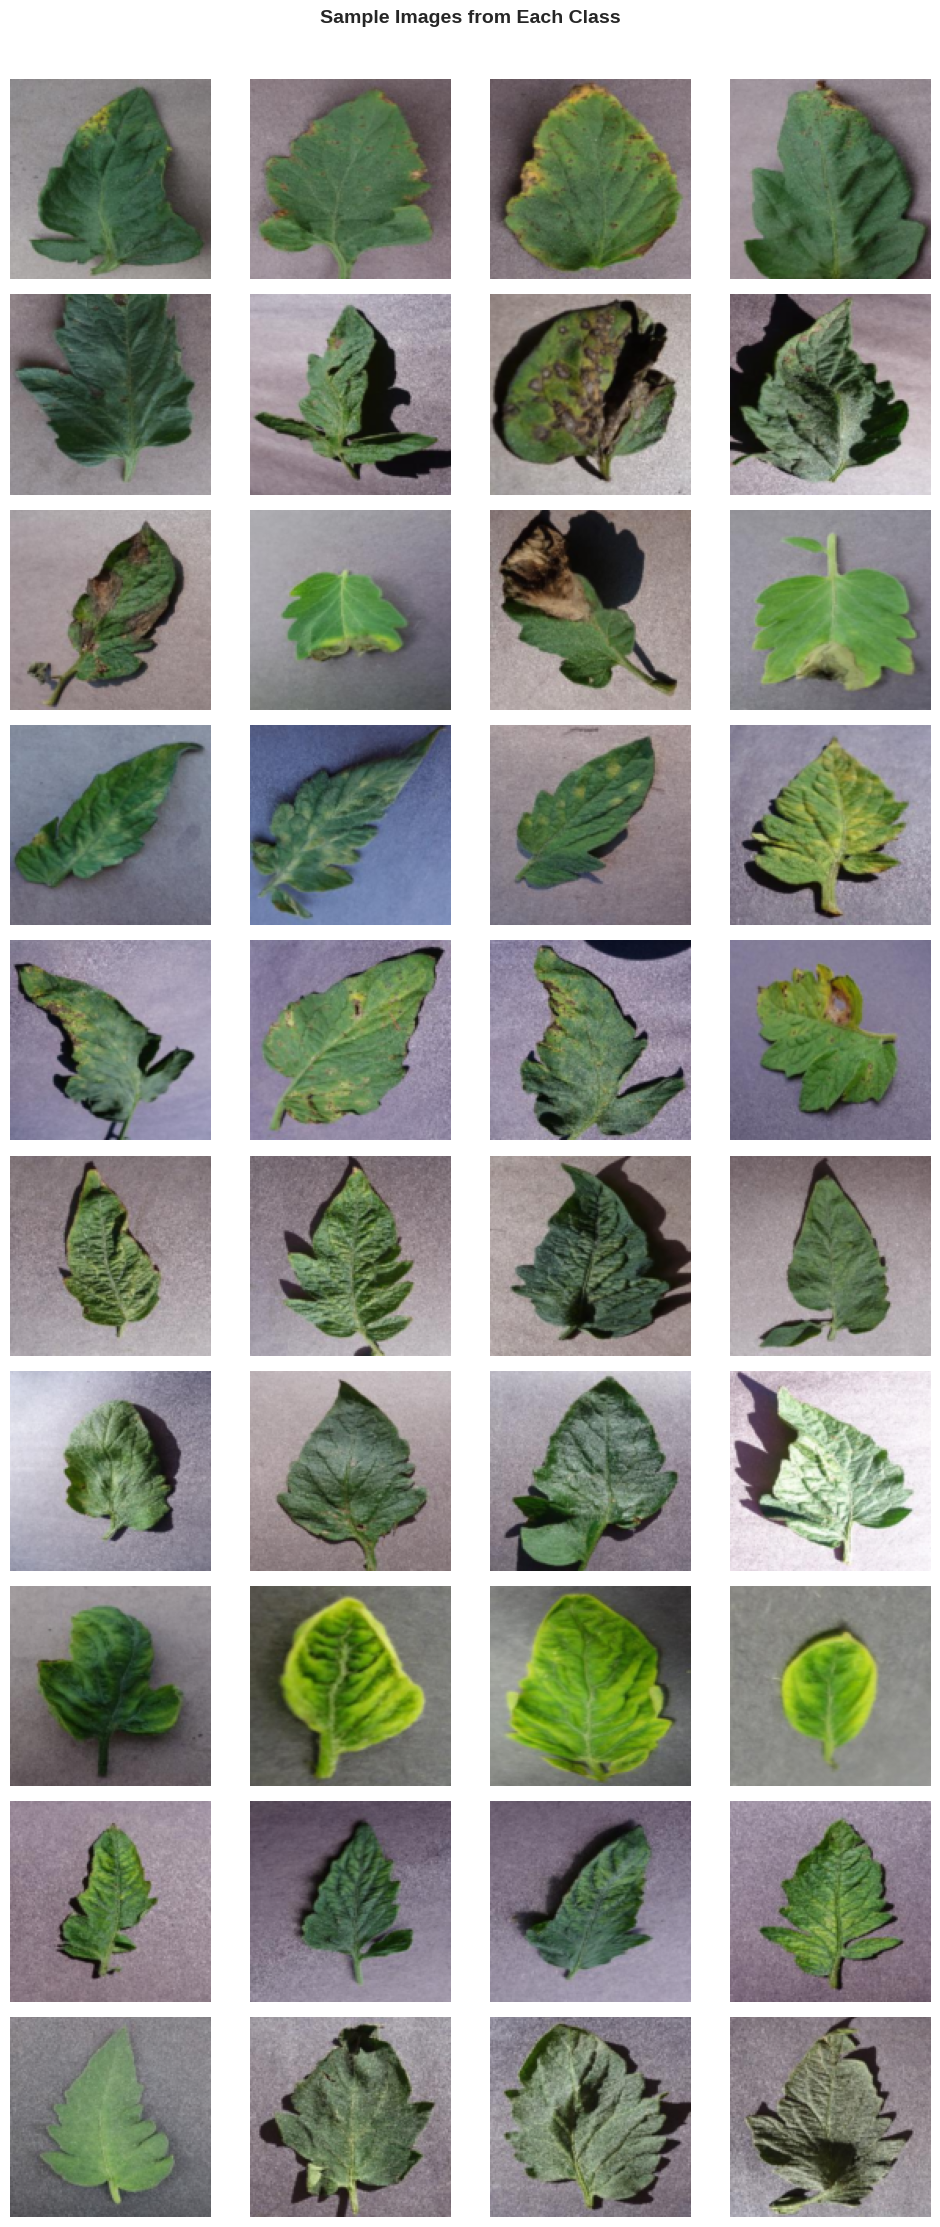

In [8]:
# =============================================================================
# 3.3 SAMPLE IMAGES GRID
# =============================================================================

def plot_sample_grid(dataset, class_names, samples_per_class=3):
    """
    Display a grid of sample images from each class.
    """
    n_classes = len(class_names)
    fig, axes = plt.subplots(n_classes, samples_per_class, 
                             figsize=(samples_per_class * 2.5, n_classes * 2.2))
    
    # Get indices for each class
    class_indices = defaultdict(list)
    for idx, (_, label) in enumerate(dataset.samples):
        class_indices[label].append(idx)
    
    np.random.seed(RANDOM_SEED)
    
    for i, class_name in enumerate(class_names):
        # Sample random indices
        indices = class_indices[i]
        sample_idx = np.random.choice(indices, min(samples_per_class, len(indices)), replace=False)
        
        for j in range(samples_per_class):
            ax = axes[i, j]
            
            if j < len(sample_idx):
                img, _ = dataset[sample_idx[j]]
                # Convert tensor to displayable image
                img_np = img.permute(1, 2, 0).numpy()
                ax.imshow(img_np)
            
            ax.axis('off')
            
            # Add class label on first column
            if j == 0:
                ax.set_ylabel(class_name[:18], fontsize=9, rotation=0, 
                              ha='right', va='center', labelpad=60)
    
    plt.suptitle('Sample Images from Each Class', fontsize=14, fontweight='bold', y=1.01)
    plt.tight_layout()
    
    # Save
    fig_path = PATHS.OUTPUTS / 'fig_06_sample_grid.png'
    plt.savefig(fig_path, dpi=150, bbox_inches='tight', facecolor='white')
    print(f"✓ Figure saved: {fig_path}")
    
    plt.show()

# Plot sample grid
plot_sample_grid(raw_dataset, CLASS_NAMES_DISPLAY, samples_per_class=4)

---

## 4. Spectral Signature Analysis (Biophysical Fingerprints)

In [9]:
# =============================================================================
# 4.1 SPECTRAL DENSITY ANALYSIS (YOUR ORIGINAL CODE - ENHANCED)
# =============================================================================

def compute_spectral_signatures(dataset, class_names, samples_per_class=150):
    """
    Compute RGB spectral signatures for each class.
    
    The spectral signature represents the distribution of mean reflectance
    values across R, G, B channels, which correlates with:
    - Red: Anthocyanins, necrosis, senescence
    - Green: Chlorophyll content (healthy tissue)
    - Blue: Structural cell wall components
    
    Args:
        dataset: PyTorch dataset
        class_names: List of class names
        samples_per_class: Number of samples to analyze per class
    
    Returns:
        Dictionary with RGB values per class
    """
    color_stats = {name: {'R': [], 'G': [], 'B': []} for name in class_names}
    counts = {name: 0 for name in class_names}
    
    print(f"\nAnalyzing spectral signatures ({samples_per_class} samples/class)...")
    
    # Get class indices
    class_indices = defaultdict(list)
    for idx, (_, label) in enumerate(dataset.samples):
        class_indices[label].append(idx)
    
    for class_idx, indices in tqdm(class_indices.items(), desc="Classes"):
        class_name = class_names[class_idx]
        
        # Random sample
        np.random.seed(RANDOM_SEED + class_idx)
        sample_indices = np.random.choice(indices, min(samples_per_class, len(indices)), replace=False)
        
        for idx in sample_indices:
            img, _ = dataset[idx]
            
            # Compute mean reflectance per channel
            color_stats[class_name]['R'].append(img[0].mean().item())
            color_stats[class_name]['G'].append(img[1].mean().item())
            color_stats[class_name]['B'].append(img[2].mean().item())
    
    return color_stats

# Compute spectral signatures
spectral_data = compute_spectral_signatures(raw_dataset, CLASS_NAMES_DISPLAY, samples_per_class=200)


Analyzing spectral signatures (200 samples/class)...


Classes:   0%|          | 0/10 [00:00<?, ?it/s]

In [10]:
# =============================================================================
# 4.2 SPECTRAL DENSITY PLOTS (10-CLASS MATRIX)
# =============================================================================

def plot_spectral_matrix(spectral_data, class_names):
    """
    Plot RGB spectral density for all classes in a matrix layout.
    """
    n_classes = len(class_names)
    n_cols = 2
    n_rows = (n_classes + 1) // 2
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, n_rows * 3.5))
    axes = axes.flatten()
    
    for i, name in enumerate(class_names):
        ax = axes[i]
        
        # Plot KDE for each channel
        sns.kdeplot(spectral_data[name]['R'], color='#ef4444', 
                    label='Red (Anthocyanins)', ax=ax, fill=True, alpha=0.2, linewidth=2)
        sns.kdeplot(spectral_data[name]['G'], color='#10b981', 
                    label='Green (Chlorophyll)', ax=ax, fill=True, alpha=0.2, linewidth=2)
        sns.kdeplot(spectral_data[name]['B'], color='#3b82f6', 
                    label='Blue (Structural)', ax=ax, fill=True, alpha=0.2, linewidth=2)
        
        # Styling
        ax.set_title(f"{name}", fontsize=11, fontweight='bold')
        ax.set_xlabel('Mean Reflectance Intensity')
        ax.set_ylabel('Density')
        ax.set_xlim(0, 1)
        
        # Only show legend on first plot
        if i == 0:
            ax.legend(loc='upper right', fontsize=8)
    
    # Hide extra subplots if odd number of classes
    for j in range(i + 1, len(axes)):
        axes[j].set_visible(False)
    
    plt.suptitle('Multi-Class Spectral Density Analysis\nBiophysical Pigment Signatures', 
                 fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()
    
    # Save
    fig_path = PATHS.OUTPUTS / 'fig_07_spectral_signatures.png'
    plt.savefig(fig_path, dpi=150, bbox_inches='tight', facecolor='white')
    print(f"✓ Figure saved: {fig_path}")
    
    plt.show()

# Plot spectral matrix
plot_spectral_matrix(spectral_data, CLASS_NAMES_DISPLAY)

✓ Figure saved: /home/maliciit/ml-projects/python-projects/plant-village-cae/outputs/fig_07_spectral_signatures.png


Healthy class identified: 'Healthy'
Diseased classes: 9
✓ Figure saved: /home/maliciit/ml-projects/python-projects/plant-village-cae/outputs/fig_08_healthy_vs_diseased_spectral.png


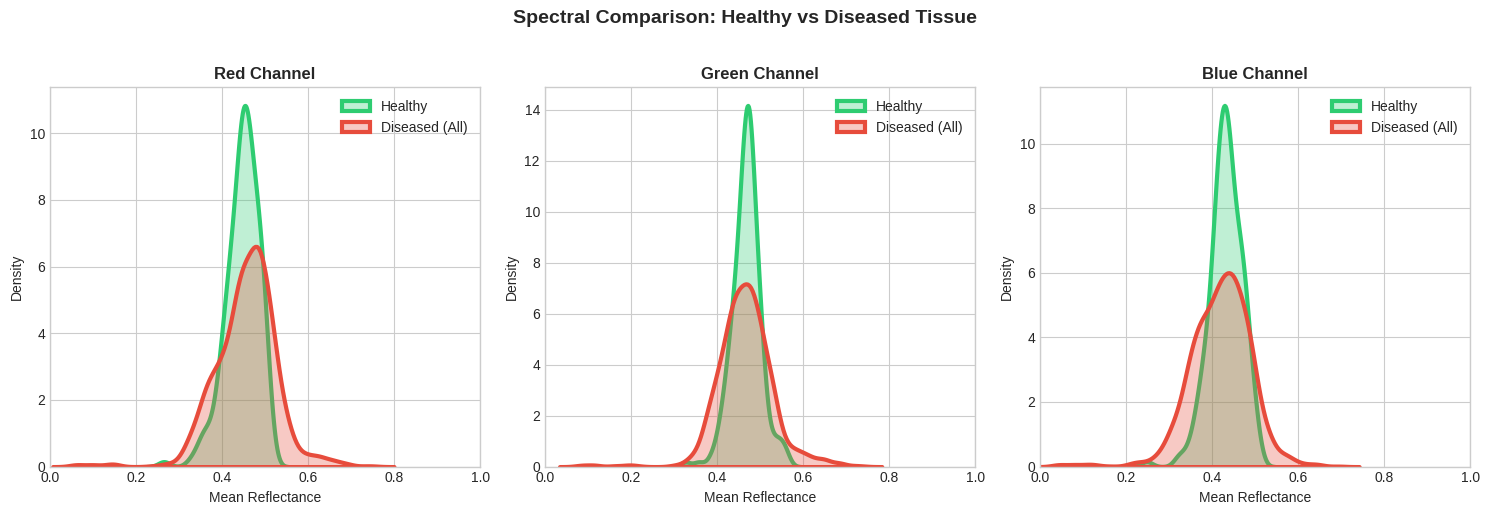

In [11]:
# =============================================================================
# 4.3 SPECTRAL COMPARISON: HEALTHY vs DISEASED
# =============================================================================

def plot_healthy_vs_diseased(spectral_data, class_names):
    """
    Compare spectral signatures between healthy and diseased classes.
    """
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # Find healthy class (case-insensitive search)
    healthy_candidates = [n for n in class_names if 'healthy' in n.lower()]
    
    if not healthy_candidates:
        print("⚠ No 'Healthy' class found in class names.")
        print(f"  Available classes: {class_names}")
        print("  Skipping healthy vs diseased comparison.")
        plt.close(fig)
        return
    
    healthy_name = healthy_candidates[0]
    diseased_names = [n for n in class_names if 'healthy' not in n.lower()]
    
    print(f"Healthy class identified: '{healthy_name}'")
    print(f"Diseased classes: {len(diseased_names)}")
    
    channels = [('R', '#ef4444', 'Red Channel'), 
                ('G', '#10b981', 'Green Channel'), 
                ('B', '#3b82f6', 'Blue Channel')]
    
    for ax, (ch, color, title) in zip(axes, channels):
        # Plot healthy
        sns.kdeplot(spectral_data[healthy_name][ch], color='#2ecc71', 
                    label='Healthy', ax=ax, fill=True, alpha=0.3, linewidth=3)
        
        # Plot all diseased (aggregated)
        diseased_values = []
        for name in diseased_names:
            diseased_values.extend(spectral_data[name][ch])
        
        sns.kdeplot(diseased_values, color='#e74c3c', 
                    label='Diseased (All)', ax=ax, fill=True, alpha=0.3, linewidth=3)
        
        ax.set_title(title, fontsize=12, fontweight='bold')
        ax.set_xlabel('Mean Reflectance')
        ax.set_ylabel('Density')
        ax.legend()
        ax.set_xlim(0, 1)
    
    plt.suptitle('Spectral Comparison: Healthy vs Diseased Tissue', 
                 fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    
    # Save
    fig_path = PATHS.OUTPUTS / 'fig_08_healthy_vs_diseased_spectral.png'
    plt.savefig(fig_path, dpi=150, bbox_inches='tight', facecolor='white')
    print(f"✓ Figure saved: {fig_path}")
    
    plt.show()

# Plot comparison
plot_healthy_vs_diseased(spectral_data, CLASS_NAMES_DISPLAY)

In [12]:
# =============================================================================
# 4.4 DISEASE ANOMALY HEATMAPS (YOUR ORIGINAL CODE - ENHANCED)
# =============================================================================

def plot_disease_heatmaps(dataset, class_names):
    """
    Generate color-anomaly heatmaps showing deviation from healthy chlorophyll.
    
    The heatmap highlights regions that deviate from "healthy green" (HSV hue ~60),
    which typically corresponds to diseased tissue (yellowing, browning, necrosis).
    """
    n_classes = len(class_names)
    n_cols = 5
    n_rows = (n_classes + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 3.5, n_rows * 3.5))
    axes = axes.flatten()
    
    # Ideal healthy green in HSV (Hue ~60 is pure green)
    IDEAL_GREEN_HUE = 60
    
    # Get one sample per class
    class_indices = defaultdict(list)
    for idx, (_, label) in enumerate(dataset.samples):
        class_indices[label].append(idx)
    
    for i, class_name in enumerate(class_names):
        ax = axes[i]
        
        # Get a representative sample
        np.random.seed(RANDOM_SEED + i)
        idx = np.random.choice(class_indices[i])
        img_tensor, _ = dataset[idx]
        
        # Convert to numpy RGB image
        img = (img_tensor.permute(1, 2, 0).numpy() * 255).astype(np.uint8)
        
        # Convert to HSV
        hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        
        # Calculate deviation from healthy green hue
        hue_diff = np.abs(hsv[:, :, 0].astype(np.int32) - IDEAL_GREEN_HUE)
        
        # Normalize to anomaly score [0-255]
        anomaly_score = np.clip(hue_diff * 3, 0, 255).astype(np.uint8)
        
        # Smooth for visualization
        anomaly_score = cv2.GaussianBlur(anomaly_score, (7, 7), 0)
        
        # Apply colormap
        heatmap = cv2.applyColorMap(anomaly_score, cv2.COLORMAP_JET)
        heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
        
        # Create background mask
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        _, mask = cv2.threshold(gray, 15, 255, cv2.THRESH_BINARY)
        mask_3d = cv2.merge([mask, mask, mask])
        
        # Alpha blend: 60% original, 40% heatmap
        overlay = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)
        overlay = cv2.bitwise_and(overlay, mask_3d)
        
        # Display
        ax.imshow(overlay)
        ax.set_title(class_name[:20], fontsize=10, fontweight='bold')
        ax.axis('off')
    
    # Hide extra axes
    for j in range(i + 1, len(axes)):
        axes[j].set_visible(False)
    
    plt.suptitle('Spectral Anomaly Mapping\nDeviation from Healthy Chlorophyll (Green → Red = Increasing Anomaly)', 
                 fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    
    # Save
    fig_path = PATHS.OUTPUTS / 'fig_09_anomaly_heatmaps.png'
    plt.savefig(fig_path, dpi=150, bbox_inches='tight', facecolor='white')
    print(f"✓ Figure saved: {fig_path}")
    
    plt.show()

# Generate heatmaps
plot_disease_heatmaps(raw_dataset, CLASS_NAMES_DISPLAY)

✓ Figure saved: /home/maliciit/ml-projects/python-projects/plant-village-cae/outputs/fig_09_anomaly_heatmaps.png


---

## 5. Stratified Train/Validation/Test Split

In [13]:
# =============================================================================
# 5.1 CREATE STRATIFIED SPLITS
# =============================================================================

# Split ratios
TRAIN_RATIO = 0.80
VAL_RATIO = 0.10
TEST_RATIO = 0.10

assert abs(TRAIN_RATIO + VAL_RATIO + TEST_RATIO - 1.0) < 1e-6, "Ratios must sum to 1.0"

def create_stratified_split(dataset, train_ratio, val_ratio, test_ratio, random_seed=42):
    """
    Create stratified train/val/test splits maintaining class proportions.
    
    Args:
        dataset: PyTorch ImageFolder dataset
        train_ratio, val_ratio, test_ratio: Split ratios (must sum to 1.0)
        random_seed: For reproducibility
    
    Returns:
        Dictionary with train/val/test file paths and labels
    """
    # Extract file paths and labels
    file_paths = [s[0] for s in dataset.samples]
    labels = [s[1] for s in dataset.samples]
    
    # First split: train vs (val + test)
    train_paths, temp_paths, train_labels, temp_labels = train_test_split(
        file_paths, labels,
        train_size=train_ratio,
        stratify=labels,
        random_state=random_seed
    )
    
    # Second split: val vs test (from the remaining data)
    relative_val_ratio = val_ratio / (val_ratio + test_ratio)
    val_paths, test_paths, val_labels, test_labels = train_test_split(
        temp_paths, temp_labels,
        train_size=relative_val_ratio,
        stratify=temp_labels,
        random_state=random_seed
    )
    
    splits = {
        'train': {'paths': train_paths, 'labels': train_labels},
        'val': {'paths': val_paths, 'labels': val_labels},
        'test': {'paths': test_paths, 'labels': test_labels}
    }
    
    return splits

# Create splits
splits = create_stratified_split(
    raw_dataset, 
    TRAIN_RATIO, VAL_RATIO, TEST_RATIO, 
    random_seed=RANDOM_SEED
)

# Print summary
print("\n" + "="*60)
print("STRATIFIED SPLIT SUMMARY")
print("="*60)
print(f"{'Split':<10} | {'Images':>10} | {'Percentage':>12}")
print("-"*40)

total = len(raw_dataset)
for split_name, split_data in splits.items():
    n = len(split_data['paths'])
    pct = n / total * 100
    print(f"{split_name:<10} | {n:>10,} | {pct:>11.1f}%")

print("-"*40)
print(f"{'TOTAL':<10} | {total:>10,} | {'100.0':>11}%")


STRATIFIED SPLIT SUMMARY
Split      |     Images |   Percentage
----------------------------------------
train      |     14,528 |        80.0%
val        |      1,816 |        10.0%
test       |      1,816 |        10.0%
----------------------------------------
TOTAL      |     18,160 |       100.0%


In [14]:
# =============================================================================
# 5.2 VERIFY STRATIFICATION
# =============================================================================

def verify_stratification(splits, class_names):
    """
    Verify that class proportions are maintained across splits.
    """
    print("\n" + "="*80)
    print("STRATIFICATION VERIFICATION")
    print("="*80)
    
    # Compute class distribution for each split
    distributions = {}
    
    for split_name, split_data in splits.items():
        labels = split_data['labels']
        total = len(labels)
        
        dist = {}
        for class_idx in range(len(class_names)):
            count = labels.count(class_idx)
            dist[class_idx] = count / total * 100
        
        distributions[split_name] = dist
    
    # Print comparison table
    print(f"\n{'Class':<25} | {'Train %':>10} | {'Val %':>10} | {'Test %':>10} | {'Max Diff':>10}")
    print("-"*80)
    
    max_deviations = []
    
    for class_idx, class_name in enumerate(class_names):
        train_pct = distributions['train'][class_idx]
        val_pct = distributions['val'][class_idx]
        test_pct = distributions['test'][class_idx]
        
        # Calculate maximum deviation
        max_diff = max(abs(train_pct - val_pct), abs(train_pct - test_pct), abs(val_pct - test_pct))
        max_deviations.append(max_diff)
        
        status = "✓" if max_diff < 1.0 else "⚠"
        print(f"{class_name[:24]:<25} | {train_pct:>9.1f}% | {val_pct:>9.1f}% | {test_pct:>9.1f}% | {max_diff:>9.2f}% {status}")
    
    print("-"*80)
    print(f"\nMaximum deviation across all classes: {max(max_deviations):.2f}%")
    print("(Deviation < 1% indicates good stratification)")
    
    return distributions

# Verify
split_distributions = verify_stratification(splits, CLASS_NAMES_DISPLAY)


STRATIFICATION VERIFICATION

Class                     |    Train % |      Val % |     Test % |   Max Diff
--------------------------------------------------------------------------------
Bacterial Spot            |      11.7% |      11.7% |      11.7% |      0.06% ✓
Early Blight              |       5.5% |       5.5% |       5.5% |      0.00% ✓
Late Blight               |      10.5% |      10.5% |      10.5% |      0.01% ✓
Leaf Mold                 |       5.2% |       5.3% |       5.2% |      0.06% ✓
Septoria Leaf Spot        |       9.8% |       9.7% |       9.7% |      0.01% ✓
Spider Mites Two-Spotted  |       9.2% |       9.2% |       9.3% |      0.06% ✓
Target Spot               |       7.7% |       7.7% |       7.8% |      0.06% ✓
Tomato Yellow Leaf Curl   |      29.5% |      29.5% |      29.5% |      0.06% ✓
Tomato Mosaic Virus       |       2.1% |       2.1% |       2.0% |      0.06% ✓
Healthy                   |       8.8% |       8.8% |       8.8% |      0.01% ✓
-----------

In [15]:
# =============================================================================
# 5.3 COPY FILES TO SPLIT DIRECTORIES
# =============================================================================

def create_split_directories(splits, class_names_raw, output_base_dir, force=False):
    """
    Copy files to train/val/test directories maintaining class structure.
    """
    output_base = Path(output_base_dir)
    
    # Check if split folders already have data (not just tomato folder)
    existing_splits = [d for d in ['train', 'val', 'test'] if (output_base / d).exists()]
    
    if existing_splits and not force:
        print(f"⚠ Split directories already exist at {output_base}")
        print(f"  Found: {existing_splits}")
        print("  Set force=True to recreate, or skip this cell.")
        return False
    
    print(f"\nCreating split directories at: {output_base}")
    print("="*60)
    
    for split_name, split_data in splits.items():
        split_dir = output_base / split_name
        
        # Remove existing split directory if force=True
        if split_dir.exists() and force:
            shutil.rmtree(split_dir)
        
        # Create class subdirectories
        for class_name in class_names_raw:
            (split_dir / class_name).mkdir(parents=True, exist_ok=True)
        
        # Copy files
        print(f"\n{split_name.upper()}: Copying {len(split_data['paths']):,} files...")
        
        for src_path, label in tqdm(zip(split_data['paths'], split_data['labels']), 
                                     total=len(split_data['paths']),
                                     desc=f"  {split_name}"):
            src = Path(src_path)
            class_name = class_names_raw[label]
            dst = split_dir / class_name / src.name
            
            shutil.copy2(src, dst)
    
    print("\n" + "="*60)
    print("✓ Split directories created successfully!")
    
    # Verify counts
    print("\nVerification:")
    for split_name in ['train', 'val', 'test']:
        split_dir = output_base / split_name
        count = sum(len(list((split_dir / c).glob('*'))) for c in class_names_raw)
        print(f"  {split_name}: {count:,} files")
    
    return True

# Create split directories - FORCE RECREATE
create_split_directories(
    splits, 
    CLASS_NAMES_RAW, 
    PATHS.DATA_PROCESSED,
    force=True  # Force recreate
)


Creating split directories at: /home/maliciit/ml-projects/python-projects/plant-village-cae/data/processed

TRAIN: Copying 14,528 files...


  train:   0%|          | 0/14528 [00:00<?, ?it/s]


VAL: Copying 1,816 files...


  val:   0%|          | 0/1816 [00:00<?, ?it/s]


TEST: Copying 1,816 files...


  test:   0%|          | 0/1816 [00:00<?, ?it/s]


✓ Split directories created successfully!

Verification:
  train: 14,528 files
  val: 1,816 files
  test: 1,816 files


True

---

## 6. Compute Normalization Statistics (Training Set Only)

In [16]:
# =============================================================================
# 6.1 COMPUTE CHANNEL-WISE MEAN AND STD FROM TRAINING DATA
# =============================================================================

def compute_normalization_stats(data_dir: Path, image_size: int = 128):
    """
    Compute channel-wise mean and standard deviation from training data.
    
    CRITICAL: These statistics must be computed ONLY from training data
    to prevent data leakage.
    
    Args:
        data_dir: Path to training data directory
        image_size: Target image size
    
    Returns:
        Tuple of (mean, std) for each channel
    """
    transform = transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor()
    ])
    
    dataset = datasets.ImageFolder(data_dir, transform=transform)
    
    print(f"\nComputing normalization statistics from {len(dataset):,} training images...")
    print("(This ensures no data leakage from val/test sets)")
    
    # Use running statistics for memory efficiency
    channel_sum = torch.zeros(3)
    channel_sq_sum = torch.zeros(3)
    n_pixels = 0
    
    for img, _ in tqdm(dataset, desc="Processing images"):
        # img shape: [3, H, W]
        channel_sum += img.sum(dim=[1, 2])
        channel_sq_sum += (img ** 2).sum(dim=[1, 2])
        n_pixels += img.shape[1] * img.shape[2]
    
    # Compute mean and std
    mean = channel_sum / n_pixels
    std = torch.sqrt(channel_sq_sum / n_pixels - mean ** 2)
    
    return mean.tolist(), std.tolist()

# Compute from training set only
train_dir = PATHS.DATA_PROCESSED / 'train'

if train_dir.exists():
    NORM_MEAN, NORM_STD = compute_normalization_stats(train_dir, IMAGE_SIZE)
    
    print("\n" + "="*60)
    print("NORMALIZATION STATISTICS (Training Set Only)")
    print("="*60)
    print(f"Mean (R, G, B): [{NORM_MEAN[0]:.4f}, {NORM_MEAN[1]:.4f}, {NORM_MEAN[2]:.4f}]")
    print(f"Std  (R, G, B): [{NORM_STD[0]:.4f}, {NORM_STD[1]:.4f}, {NORM_STD[2]:.4f}]")
    print("\n⚠ These values MUST be used for val/test transforms!")
else:
    print("⚠ Training directory not found. Using default values.")
    NORM_MEAN = [0.5, 0.5, 0.5]
    NORM_STD = [0.5, 0.5, 0.5]


Computing normalization statistics from 14,528 training images...
(This ensures no data leakage from val/test sets)


Processing images:   0%|          | 0/14528 [00:00<?, ?it/s]


NORMALIZATION STATISTICS (Training Set Only)
Mean (R, G, B): [0.4504, 0.4662, 0.4011]
Std  (R, G, B): [0.1742, 0.1514, 0.1907]

⚠ These values MUST be used for val/test transforms!


---

## 7. Export Configuration & Metadata

In [17]:
# =============================================================================
# 7.1 SAVE SPLIT METADATA
# =============================================================================

# Create comprehensive metadata
split_metadata = {
    'created_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'random_seed': RANDOM_SEED,
    
    'split_ratios': {
        'train': TRAIN_RATIO,
        'val': VAL_RATIO,
        'test': TEST_RATIO
    },
    
    'split_counts': {
        'train': len(splits['train']['paths']),
        'val': len(splits['val']['paths']),
        'test': len(splits['test']['paths']),
        'total': len(raw_dataset)
    },
    
    'paths': {
        'train': str(PATHS.DATA_PROCESSED / 'train'),
        'val': str(PATHS.DATA_PROCESSED / 'val'),
        'test': str(PATHS.DATA_PROCESSED / 'test')
    },
    
    'image_config': {
        'size': IMAGE_SIZE,
        'channels': 3,
        'color_mode': 'RGB'
    },
    
    'normalization': {
        'mean': NORM_MEAN,
        'std': NORM_STD,
        'computed_from': 'training_set_only'
    },
    
    'classes': {
        'names_raw': CLASS_NAMES_RAW,
        'names_display': CLASS_NAMES_DISPLAY,
        'num_classes': len(CLASS_NAMES_RAW),
        'idx_to_class': {i: name for i, name in enumerate(CLASS_NAMES_RAW)},
        'class_to_idx': {name: i for i, name in enumerate(CLASS_NAMES_RAW)}
    }
}

# Save metadata
metadata_path = PATHS.CONFIG / 'split_metadata.json'
metadata_path.parent.mkdir(parents=True, exist_ok=True)

with open(metadata_path, 'w') as f:
    json.dump(split_metadata, f, indent=2)

print(f"✓ Metadata saved: {metadata_path}")

# Display saved config
print("\n" + "="*60)
print("EXPORTED METADATA")
print("="*60)
print(json.dumps(split_metadata, indent=2))

✓ Metadata saved: /home/maliciit/ml-projects/python-projects/plant-village-cae/config/split_metadata.json

EXPORTED METADATA
{
  "created_date": "2026-01-27 18:15:53",
  "random_seed": 42,
  "split_ratios": {
    "train": 0.8,
    "val": 0.1,
    "test": 0.1
  },
  "split_counts": {
    "train": 14528,
    "val": 1816,
    "test": 1816,
    "total": 18160
  },
  "paths": {
    "train": "/home/maliciit/ml-projects/python-projects/plant-village-cae/data/processed/train",
    "val": "/home/maliciit/ml-projects/python-projects/plant-village-cae/data/processed/val",
    "test": "/home/maliciit/ml-projects/python-projects/plant-village-cae/data/processed/test"
  },
  "image_config": {
    "size": 128,
    "channels": 3,
    "color_mode": "RGB"
  },
  "normalization": {
    "mean": [
      0.45038148760795593,
      0.4661545753479004,
      0.4010584056377411
    ],
    "std": [
      0.17417825758457184,
      0.1513632982969284,
      0.19069136679172516
    ],
    "computed_from": "traini

In [18]:
# =============================================================================
# 7.2 VISUALIZATION: SPLIT DISTRIBUTION
# =============================================================================

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Overall split distribution
ax1 = axes[0]
split_names = ['Train', 'Validation', 'Test']
split_counts = [split_metadata['split_counts']['train'],
                split_metadata['split_counts']['val'],
                split_metadata['split_counts']['test']]
colors = ['#3498db', '#f39c12', '#e74c3c']

wedges, texts, autotexts = ax1.pie(
    split_counts, 
    labels=split_names, 
    autopct='%1.1f%%',
    colors=colors,
    explode=[0.02, 0.02, 0.02],
    startangle=90
)
ax1.set_title('Data Split Distribution', fontsize=13, fontweight='bold')

# Add count legend
legend_labels = [f'{name}: {count:,}' for name, count in zip(split_names, split_counts)]
ax1.legend(wedges, legend_labels, loc='lower left', fontsize=10)

# Plot 2: Class distribution per split
ax2 = axes[1]

x = np.arange(len(CLASS_NAMES_DISPLAY))
width = 0.25

train_counts = [splits['train']['labels'].count(i) for i in range(len(CLASS_NAMES_DISPLAY))]
val_counts = [splits['val']['labels'].count(i) for i in range(len(CLASS_NAMES_DISPLAY))]
test_counts = [splits['test']['labels'].count(i) for i in range(len(CLASS_NAMES_DISPLAY))]

bars1 = ax2.bar(x - width, train_counts, width, label='Train', color='#3498db', alpha=0.8)
bars2 = ax2.bar(x, val_counts, width, label='Validation', color='#f39c12', alpha=0.8)
bars3 = ax2.bar(x + width, test_counts, width, label='Test', color='#e74c3c', alpha=0.8)

ax2.set_xlabel('Class', fontsize=11)
ax2.set_ylabel('Number of Images', fontsize=11)
ax2.set_title('Class Distribution Across Splits', fontsize=13, fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels([n[:12] for n in CLASS_NAMES_DISPLAY], rotation=45, ha='right', fontsize=8)
ax2.legend()

plt.tight_layout()

# Save
fig_path = PATHS.OUTPUTS / 'fig_10_split_distribution.png'
plt.savefig(fig_path, dpi=150, bbox_inches='tight', facecolor='white')
print(f"✓ Figure saved: {fig_path}")

plt.show()

✓ Figure saved: /home/maliciit/ml-projects/python-projects/plant-village-cae/outputs/fig_10_split_distribution.png


---

## 8. Summary & Next Steps

### ✅ Completed in This Notebook

1. **Data subsetting** — Extracted 10 Tomato classes from PlantVillage
2. **Comprehensive EDA** — Class distribution, pixel statistics, sample visualization
3. **Spectral analysis** — RGB biophysical fingerprints, disease anomaly heatmaps
4. **Stratified splitting** — 80/10/10 train/val/test with verified class proportions
5. **Normalization statistics** — Computed from training set only (no leakage)
6. **Metadata export** — JSON config for downstream notebooks

### 📊 Key Statistics

| Metric | Value |
|--------|-------|
| Training images | ~14,400 |
| Validation images | ~1,800 |
| Test images | ~1,800 |
| Image size | 128×128×3 |
| Normalization (μ) | Computed from training |
| Normalization (σ) | Computed from training |

### ⚠️ Critical Notes for Downstream Notebooks

1. **Always load `split_metadata.json`** for normalization values
2. **Never compute statistics from val/test data**
3. **Use the same random seed (42)** for reproducibility

### ➡️ Next Notebook: `3_CAE_Training.ipynb`

- Convolutional Autoencoder architecture
- Self-supervised pre-training
- Reconstruction metrics (MSE, SSIM, PSNR)

In [19]:
# =============================================================================
# NOTEBOOK COMPLETION
# =============================================================================

print("\n" + "="*60)
print("✓ NOTEBOOK 2 COMPLETE")
print("="*60)
print(f"Execution finished at: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"\nGenerated figures saved to: {PATHS.OUTPUTS}")
print(f"Configuration saved to: {PATHS.CONFIG}")
print("\nProceed to: 3_CAE_Training.ipynb")


✓ NOTEBOOK 2 COMPLETE
Execution finished at: 2026-01-27 18:16:02

Generated figures saved to: /home/maliciit/ml-projects/python-projects/plant-village-cae/outputs
Configuration saved to: /home/maliciit/ml-projects/python-projects/plant-village-cae/config

Proceed to: 3_CAE_Training.ipynb
